In [1]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.camera import CameraCalibration, Camera
from src.camera.video import VideoStream
from src.segmentation.circledetector import CircleDetector
from src.pose.position_estimation import PositionEstimation
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR
from src.camera.intrinsic_matrix import find_single_intrinsic_matrix

import src.visualization.plot3D as plot3D
from src.ukf import StateVector, BallUKF, PoseMeasurementMode
from src.camera import CameraPose
from scipy.spatial.transform import Rotation

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.camera import CameraCalibration, Camera
from src.segmentation.circledetector import CircleDetector
from src.segmentation.yolo_detector import SplitYoloDetector
from src.segmentation.split_image import ImageSplitter
from src.segmentation.adjust_contrast import adjust_contrast
from src.segmentation.antismear import AntiSmear
from src.pose.position_estimation import PositionEstimation
from src.pose.velocity_regression import velocity_regression
from src.ukf import BallUKF
from src.ukf.measurement import PixelPositionMeasurementMode
from src.fileutils import DATA_DIR, MODELS_DIR, PROJECT_ROOT
import src.visualization.plot3D as plot3D
from src.parse_config import Config

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLOWorld, YOLO
from itertools import islice

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


VideoStream:
	Source: /Users/niteeshsaravanan/Documents/GitHub/PingPongTracking/data/calibration/Priyanshu_iPhone13.MOV
	FPS: 212.2765805331427
	Frames: 866
	Resolution: 1920x1080



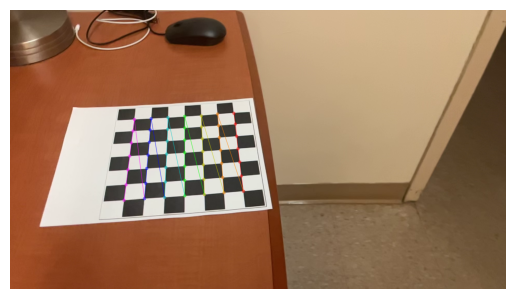

100%|█████████▉| 865/866 [00:17<00:00, 49.29it/s]


array([[     1773.2,           0,      911.69],
       [          0,      2184.9,       544.3],
       [          0,           0,           1]])

In [3]:
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV')
print(calibration_video)
find_single_intrinsic_matrix(next(calibration_video), show_image=True)
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_video, total=calibration_video.get_length_if_known()))
calibration.intrinsic_matrix

In [4]:
camera = Camera(pose=None, calibration=calibration)
ball = BallConstants()
table = TableConstants()
position_estimator = PositionEstimation(camera, ball, table)

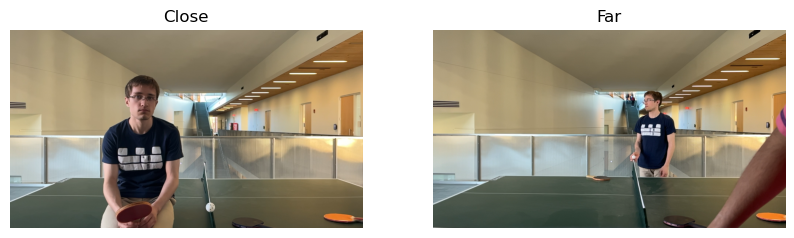

In [5]:
ping_pong_ball_close_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13_Net_Close.png'
ping_pong_ball_far_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13_Net_Far.png'

# Read images and plot on same plot
ping_pong_ball_close_image = cv2.imread(str(ping_pong_ball_close_image_path))
ping_pong_ball_far_image = cv2.imread(str(ping_pong_ball_far_image_path))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(ping_pong_ball_close_image, cv2.COLOR_BGR2RGB))
plt.title('Close')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ping_pong_ball_far_image, cv2.COLOR_BGR2RGB))
plt.title('Far')
plt.axis('off')

plt.show()

We know the length of the net. Therefore, we can test our calibration by checking estimates of the close and far ball positions.
In these images, the camera might not have been setup in precisely the same orientation. Therefore, we can expect to see some error.

4 circles detected
1 circles detected after filtering by color threshold


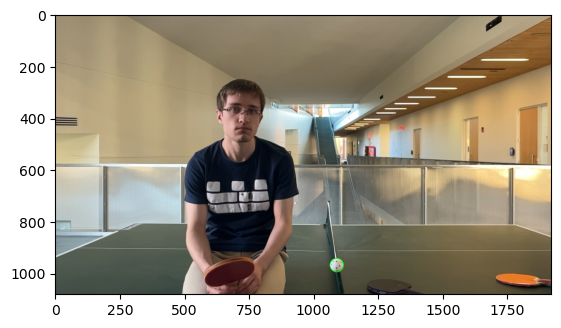

In [6]:
circle_detector = CircleDetector()
circles = circle_detector.hough_circles(ping_pong_ball_close_image, minRadius=10, maxRadius=30, param1=50, param2=30, minDist=20)
print(f"{len(circles)} circles detected")
sensitivity = 50
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])
circles = circle_detector.filter_circles_by_color_threshold(ping_pong_ball_close_image, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
print(f"{len(circles)} circles detected after filtering by color threshold")

aug_img = circle_detector.draw_circles(ping_pong_ball_close_image, circles, color=(0, 255, 0), thickness=2)
_ = plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))


In [7]:
ping_pong_ball = circles[0]
ping_pong_ball_center_x = ping_pong_ball[0]
ping_pong_ball_center_y = ping_pong_ball[1]
ping_pong_ball_radius = ping_pong_ball[2]

print(f'Center: ({ping_pong_ball_center_x}, {ping_pong_ball_center_y}), Radius: {ping_pong_ball_radius}')

ball_position_close = position_estimator.ball_position_camera_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius * 2)
print(f'Calculated Ball Position:', ball_position_close)

center_x, center_y, diameter = position_estimator.project_ball_position_camera_reference_frame_to_camera_plane(ball_position_close)

print(f'Projection of ball position: ({center_x}, {center_y}), Radius: {diameter//2}')



Center: (1090, 968), Radius: 26
Calculated Ball Position: [    0.13716     0.26451       1.364]
Projection of ball position: (1090, 968), Radius: 26


1 circles detected
1 circles detected after filtering by color threshold


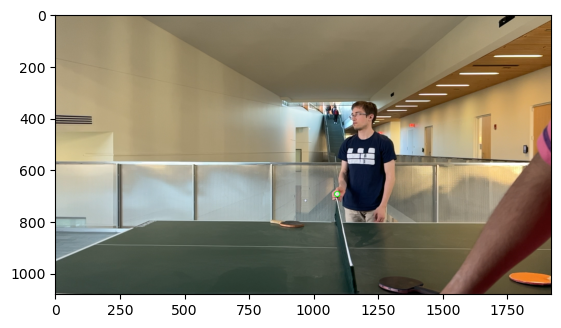

In [8]:
circles = circle_detector.hough_circles(ping_pong_ball_far_image, minRadius=5, maxRadius=20, param1=50, param2=30, minDist=10)
print(f"{len(circles)} circles detected")
sensitivity = 50
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])
circles = circle_detector.filter_circles_by_color_threshold(ping_pong_ball_far_image, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
print(f"{len(circles)} circles detected after filtering by color threshold")

aug_img = circle_detector.draw_circles(ping_pong_ball_far_image, circles, color=(0, 255, 0), thickness=2)
_ = plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))

In [9]:
ping_pong_ball = circles[0]
ping_pong_ball_center_x = ping_pong_ball[0]
ping_pong_ball_center_y = ping_pong_ball[1]
ping_pong_ball_radius = ping_pong_ball[2]

print(f'Center: ({ping_pong_ball_center_x}, {ping_pong_ball_center_y}), Radius: {ping_pong_ball_radius}')

ball_position_far = position_estimator.ball_position_camera_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius * 2)
print(f'Calculated Ball Position:', ball_position_far)

center_x, center_y, diameter = position_estimator.project_ball_position_camera_reference_frame_to_camera_plane(ball_position_far)

print(f'Projection of ball position: ({center_x}, {center_y}), Radius: {diameter//2}')


Center: (1092, 694), Radius: 10
Calculated Ball Position: [    0.36062     0.24299      3.5464]
Projection of ball position: (1092, 694), Radius: 10


In [10]:
# In the camera reference frame, we expect the difference 

print(ball_position_far - ball_position_close)
print(f"Expected difference in z-axis: {table.length}")

[    0.22346   -0.021526      2.1824]
Expected difference in z-axis: 2.74


load all images into list
x y z as a numpy array and then set up the camera and the plots

In [1]:
actual_ball_positions = np.array([
    np.array([-0.5, 0, 1]),
    np.array([-0.5, 0, 2]),
    np.array([0.5, 0, 1]),
    np.array([0.5, 0, 2]),
    np.array([0, 0.5, 1.5])
    np.array([0, 0, 0.5]),
    np.array([0, 0.25, 1.5]),
    np.array([1, 0, 2]),
    np.array([0, 0, 1]),
    np.array([0, 0, 2]),
    np.array([0, 0, 3])
])

ball = BallConstants(radius = 50e-3) # Initialize ball with defaults


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1251635557.py, line 6)

In [12]:
# Define the camera pose, we will plot it
camera_position = np.array([0, 0, 0])
camera_orientation = Rotation.from_euler('xyz', [0, 0, 0], degrees=True)
camera = CameraPose(camera_position, camera_orientation, mirror_y=False)

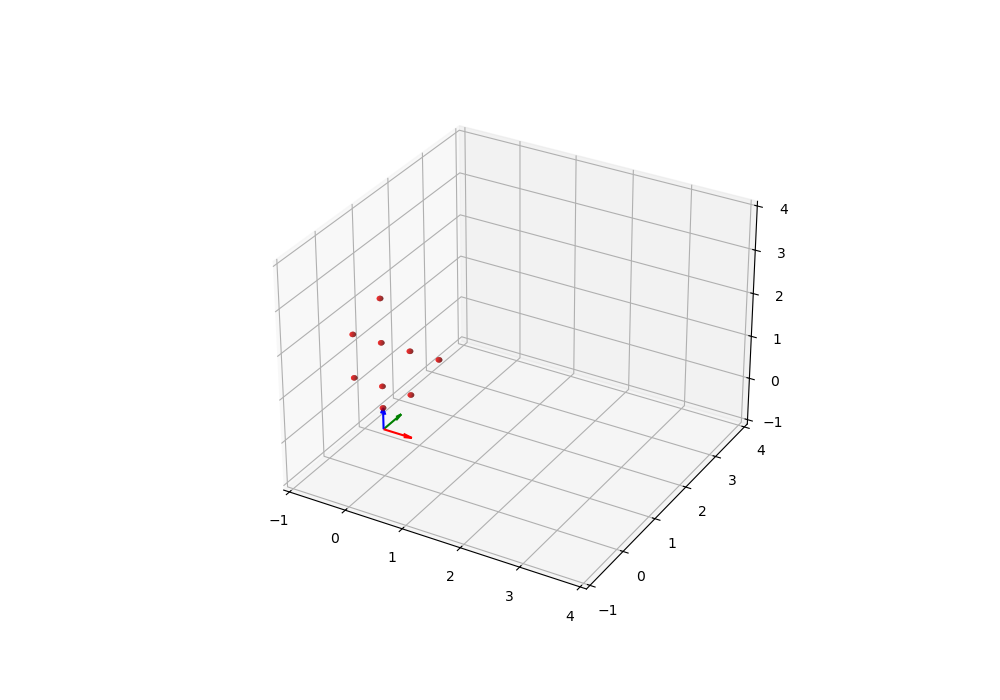

In [13]:
%matplotlib widget
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-1, 4)
ax.set_ylim3d(-1, 4)
ax.set_zlim3d(-1, 4)

plot3D.plot_camera(ax, camera)
plot3D.plot_balls(ax, ball, actual_ball_positions, color='red')
plt.show()

In [14]:
pictures_dict = {}

directory = "../data/calibration/Priyanshuiphone13"

for filename in os.listdir(directory):
    if filename.endswith(".png"):
        # Remove the file extension from the filename
        filename_without_extension = os.path.splitext(filename)[0]
        
        # Construct the full path to the image file
        filepath = os.path.join(directory, filename)
        
        # Read the image using OpenCV
        image = cv2.imread(filepath)
        
        # Check if the image was successfully loaded
        if image is not None:
            # Add the image to the dictionary with filename as key
            pictures_dict[filename_without_extension] = image
        else:
            print(f"Failed to load image: {filepath}")
"""
for k,v in pictures_dict.items():
    # Create a new figure for each image
    plt.figure()
    # Plot the image using Matplotlib
    plt.imshow(v, cmap=None)
    # Set the title of the plot
    plt.title(k)
    # Show the plot
    plt.show()"""

'\nfor k,v in pictures_dict.items():\n    # Create a new figure for each image\n    plt.figure()\n    # Plot the image using Matplotlib\n    plt.imshow(v, cmap=None)\n    # Set the title of the plot\n    plt.title(k)\n    # Show the plot\n    plt.show()'

### Prediction

In [15]:
working = pictures_dict["1z"]

In [16]:
# Init yolo
model = YOLOWorld(str(MODELS_DIR / 'yolo' / 'yolov8l-world.pt'))
model.set_classes(['person', 'sports ball', 'ball', 'ping pong ball', 'orange ball'])
ball_classes = {1, 2, 3, 4}

# Init yolo
#model = YOLO(str(MODELS_DIR / 'yolo' / 'yolov8n.pt'))
#ball_classes = {32}

model.conf = 0.01
model.iou = 0.1

# Split the frame into smaller overlapping regions
split_height = working.shape[0]
split_width = working.shape[1]
overlap = 0.2
splitter = ImageSplitter(split_height=split_height, split_width=split_width, overlap=overlap)

detector = SplitYoloDetector(model, splitter, ball_classes = ball_classes, background_diff_threshold=0.3)

initial_positions = list()

100%|██████████| 91.2M/91.2M [00:03<00:00, 31.1MB/s]


In [ ]:
for k, frame in pictures_dict.items():
    frame = adjust_contrast(working)
    box, conf = detector.detect(frame, yolo_verbose = False, debug_plots = False)
    annotated_frame = frame.copy()
    prev_center_x = 0
    prev_center_y = 0

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf}")
        detector.draw_bounding_box(annotated_frame, box, conf)

        box_center_x = (box[0] + box[2]) // 2
        box_center_y = (box[1] + box[3]) // 2
        diameter = min(box[2] - box[0], box[3] - box[1])
        print(f"Box Center: ({box_center_x}, {box_center_y}), Min Length: {diameter}")

        # Crop the ball bounding box, apply otsu thresholding 
        ball_crop = frame[box[1]:box[3], box[0]:box[2]]
        blur = cv2.GaussianBlur(ball_crop, (5, 5), 0)
        ball_mask = cv2.threshold(cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Plot the mask next to ball crop
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(ball_crop, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2)
        plt.imshow(ball_mask, cmap='gray')

        # Apply the ball mask onto the original frame
        full_frame_ball_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        full_frame_ball_mask[box[1]:box[3], box[0]:box[2]] = ball_mask
        

        center_x = box_center_x
        center_y = box_center_y

        # Get the ball position
        ball_position = position_estimator.ball_position_table_reference_frame(center_x, center_y, diameter)
        ball_position_cam = position_estimator.ball_position_camera_reference_frame(center_x, center_y, diameter)

        initial_positions.append(ball_position)
